<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/ArbitraryStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow-datasets --upgrade

     |████████████████████████████████| 4.0 MB 4.1 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.optimizers import RMSprop, Adam

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow_datasets as tfds
import os
import tempfile
import urllib

In [3]:
BATCH_SIZE = 8
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_HEIGHT = IMG_WIDTH = 256

dataset_name = 'monet2photo'

train_style, test_style = tfds.load(f'cycle_gan/{dataset_name}', split=['trainA', 'testA'], as_supervised=True)
gcs_base_dir = "gs://celeb_a_dataset/"
celeb_a_builder = tfds.builder("celeb_a", data_dir=gcs_base_dir, version='2.0.0')

celeb_a_builder.download_and_prepare()

num_test_shards_dict = {'0.3.0': 4, '2.0.0': 2} # Used because we download the test dataset separately
version = str(celeb_a_builder.info.version)
print('Celeb_A dataset version: %s' % version)

local_root = tempfile.mkdtemp(prefix='test-data')
def local_test_filename_base():
  return local_root

def local_test_file_full_prefix():
  return os.path.join(local_test_filename_base(), "celeb_a-test.tfrecord")

def copy_test_files_to_local():
  filename_base = local_test_file_full_prefix()
  num_test_shards = num_test_shards_dict[version]
  for shard in range(num_test_shards):
    url = "https://storage.googleapis.com/celeb_a_dataset/celeb_a/%s/celeb_a-test.tfrecord-0000%s-of-0000%s" % (version, shard, num_test_shards)
    filename = "%s-0000%s-of-0000%s" % (filename_base, shard, num_test_shards)
    res = urllib.request.urlretrieve(url, filename)

train_content, test_content = celeb_a_builder.as_dataset(split=['train', 'test'])
# Copy test data locally to be able to read it into tfma
copy_test_files_to_local()

def preprocess_content(sample):
    image = sample['image']
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    image = tf.cast(image, tf.float32)
    return image

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    image = tf.cast(image, tf.float32)
    return image

train_style = train_style.map(
    preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

train_content = train_content.map(
    preprocess_content, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

test_style = test_style.map(
    preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1).repeat()

test_content = test_content.map(
    preprocess_content, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1).repeat()

train_dataset = tf.data.Dataset.zip((train_content, train_style))
test_dataset = tf.data.Dataset.zip((test_content, test_style))

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.
Celeb_A dataset version: 2.0.0


In [4]:
class AdaIN(layers.Layer):

    def __init__(self, epsilon=1e-5):
        super(AdaIN, self).__init__()
        self.epsilon = epsilon
    
    def call(self, inputs):
        x, y = inputs

        mean_x, var_x = tf.nn.moments(x, axes=(1, 2), keepdims = True)
        mean_y, var_y = tf.nn.moments(y, axes=(1, 2), keepdims = True)

        std_x = tf.sqrt(var_x + self.epsilon)
        std_y = tf.sqrt(var_y + self.epsilon)
        
        #Shift x to have the same mean and variance as y
        # (transfer encoded styles)
        return std_y * (x - mean_x)/std_x + mean_y

In [5]:
def build_encoder(name='encoder'):
    encoder_layers = ['block1_conv1',
                            'block2_conv1',
                            'block3_conv1', 
                            'block4_conv1']
        
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    layer_outputs = [vgg.get_layer(x).output for x in encoder_layers]
    
    return Model(vgg.input, layer_outputs, name=name)

In [22]:
class RefConv2D(layers.Layer):

    def __init__(self, input_filters, filters, kernel, use_relu=True):
        super(RefConv2D, self).__init__()
        self.filters = filters
        self.input_filters = input_filters
        self.kernel = kernel
        self.relu = use_relu

    def build(self, input_shape):

        self.w = self.add_weight(shape = (self.kernel, self.kernel, self.input_filters, self.filters),
                                 initializer = 'glorot_normal', trainable=True, name = 'kernel')
        self.b = self.add_weight(shape=(self.filters,), initializer = 'zeros', trainable=True, name='bias')
    
    @tf.function
    def call(self, inputs):

        padded = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        output = tf.nn.conv2d(padded, self.w, strides=1, padding="VALID") + self.b

        if self.relu:
            output = tf.nn.relu(output)
        
        return output

In [20]:
def build_decoder():
        
        block = tf.keras.Sequential([\
                RefConv2D(512, 256, 3),
                UpSampling2D((2,2)),
                RefConv2D(256, 256, 3),
                RefConv2D(256, 256, 3),
                RefConv2D(256, 256, 3),
                RefConv2D(256, 128, 3),
                UpSampling2D((2,2)),
                RefConv2D(128, 128, 3),
                RefConv2D(128, 64, 3),
                UpSampling2D((2,2)),
                RefConv2D(64, 64, 3),
                RefConv2D(64, 3, 3, use_relu=False)],
                                   name='decoder')
        return block

In [8]:
def preprocess(image):
    image = tf.reverse(image, axis=[-1])
    return tf.keras.applications.vgg19.preprocess_input(image)

In [9]:
def postprocess(image):
    image = tf.clip_by_value(image, 0., 255.)
    return image

In [32]:
class ArbitraryStyleTransfer(Model):
    
    def __init__(self):
        super(ArbitraryStyleTransfer, self).__init__()

        self.encoder = build_encoder()
        self.decoder = build_decoder()
        self.adaIn = AdaIN()
        self.epsilon = 1e-5
        self.LAMBDA = 1e-4
    
    def compile(self, optimizer):
        super(ArbitraryStyleTransfer, self).compile()
        self.optimizer = optimizer
    
    def train_step(self, inputs):
        content_image, style_image = inputs

        with tf.GradientTape() as tape:
            # Encode content and style into latent space
            content = self.encoder(preprocess(content_image))
            style = self.encoder(preprocess(style_image))

            # Style is represented as mean and variance.
            # Normalize the content to have the mean and variance of style
            adain_output = self.adaIn([content[-1], style[-1]])

            # Generate image with both the style data (mean and variance), 
            # And distribution of content data
            stylized_image = postprocess(self.decoder(adain_output))
            
            # Extract features of generated Image
            # This should have the same distribution as the one we generated it with 
            output_features = self.encoder(preprocess(stylized_image))

            # If the decoder can learn to reverse the process of the encoder and
            # Learn to make an image from a distribution, rather than make a distrib from an image,
            # Then it has the ability to generate an image from any (mu, var) and distribution
            #                                                        (style)       (content)

            #Content must match to that it is trying to make
            content_loss = tf.reduce_mean((output_features[-1] - adain_output)**2)

            #Style means and variances must match to that of what it tries to 
            style_loss = 0
            for pred_style, target_style in zip(output_features, style):
                mean_pred, var_pred = tf.nn.moments(pred_style, axes=(1, 2), keepdims = True)
                mean_true, var_true = tf.nn.moments(target_style, axes=(1, 2), keepdims = True)
                std_true, std_pred = tf.sqrt(var_true+self.epsilon), tf.sqrt(var_pred+self.epsilon)
                mean_loss = tf.reduce_sum(tf.square(mean_true-mean_pred))
                std_loss = tf.reduce_sum(tf.square(std_true-std_pred))
                style_loss += (mean_loss + std_loss)

            style_loss = tf.reduce_mean(style_loss)

            loss = self.LAMBDA * style_loss + content_loss
        
        grads = tape.gradient(loss, self.decoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.decoder.trainable_variables))

        return {'loss': loss}
    
    def call(self, inputs):
        content_image, style_image = inputs
        
        content = self.encoder(preprocess(content_image))
        style = self.encoder(preprocess(style_image))

        adain_output = self.adaIn([content[-1], style[-1]])
        stylized_image = postprocess(self.decoder(adain_output))

        return stylized_image

In [39]:
class GenerativeCallback(tf.keras.callbacks.Callback):

    def __init__(self, test_dataset, num_imgs=5, interval=5):
        super(GenerativeCallback, self).__init__()
        
        self.num_imgs = num_imgs
        self.interval = interval
        self.ds = iter(test_dataset)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % self.interval) is not 0:
            return 
        grid_row = 1
        grid_col = 3
        content, style = next(self.ds)
        image_stylized = self.model((content, style))
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        axarr[0].imshow(content[0] / 255.)
        axarr[0].axis('off') 

        axarr[1].imshow(style[0] / 255.)
        axarr[1].axis('off') 

        axarr[2].imshow(image_stylized[0] / 255.)
        axarr[2].axis('off') 
        plt.show()

Epoch 1/30
  6/134 [>.............................] - ETA: 1:59 - loss: 722869.4062WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0659s vs `on_train_batch_end` time: 0.8790s). Check your callbacks.


134/134 [==============================] - 129s 929ms/step - loss: 448912.5525


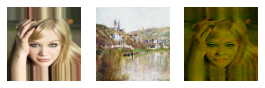

Epoch 2/30
134/134 [==============================] - 127s 927ms/step - loss: 338645.8027


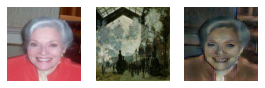

Epoch 3/30
134/134 [==============================] - 127s 927ms/step - loss: 259054.1723


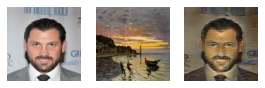

Epoch 4/30
134/134 [==============================] - 127s 928ms/step - loss: 231957.4369


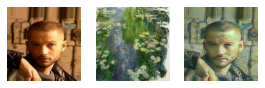

Epoch 5/30
134/134 [==============================] - 127s 930ms/step - loss: 217330.5574


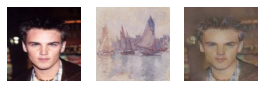

Epoch 6/30
134/134 [==============================] - 127s 929ms/step - loss: 207451.4206


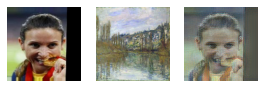

Epoch 7/30
134/134 [==============================] - 127s 931ms/step - loss: 199639.4385


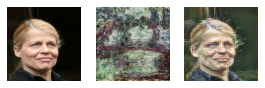

Epoch 8/30
134/134 [==============================] - 127s 931ms/step - loss: 192711.7302


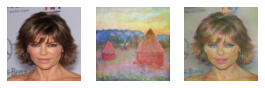

Epoch 9/30
134/134 [==============================] - 127s 929ms/step - loss: 188097.8394


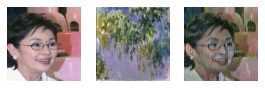

Epoch 10/30
134/134 [==============================] - 127s 929ms/step - loss: 183570.3705


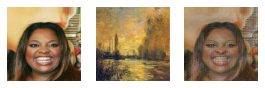

Epoch 11/30
134/134 [==============================] - 127s 930ms/step - loss: 179559.9796


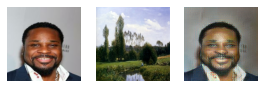

Epoch 12/30
134/134 [==============================] - 127s 930ms/step - loss: 175393.5426


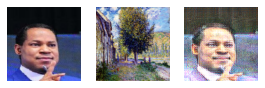

Epoch 13/30
134/134 [==============================] - 127s 930ms/step - loss: 172048.5869


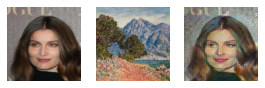

Epoch 14/30
134/134 [==============================] - 127s 930ms/step - loss: 167983.8440


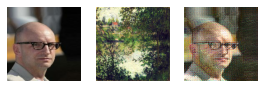

Epoch 15/30
134/134 [==============================] - 127s 930ms/step - loss: 166359.3238


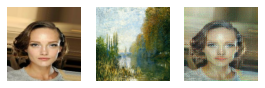

Epoch 16/30
134/134 [==============================] - 127s 930ms/step - loss: 164460.6457


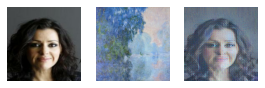

Epoch 17/30
134/134 [==============================] - 127s 931ms/step - loss: 161605.9001


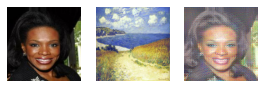

Epoch 18/30
134/134 [==============================] - 127s 930ms/step - loss: 159380.0068


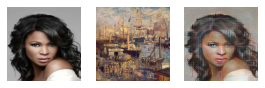

Epoch 19/30
134/134 [==============================] - 127s 930ms/step - loss: 157289.2541


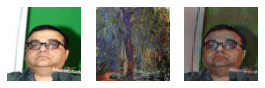

Epoch 20/30
134/134 [==============================] - 128s 931ms/step - loss: 156297.1831


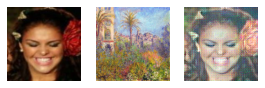

Epoch 21/30
134/134 [==============================] - 127s 931ms/step - loss: 154379.0503


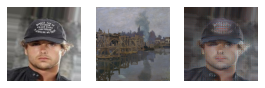

Epoch 22/30
134/134 [==============================] - 127s 932ms/step - loss: 152125.0177


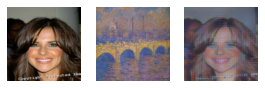

Epoch 23/30
134/134 [==============================] - 127s 931ms/step - loss: 150796.5130


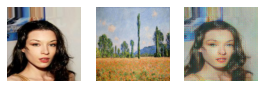

Epoch 24/30
134/134 [==============================] - 127s 933ms/step - loss: 149807.6593


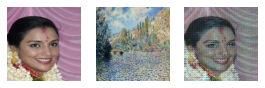

Epoch 25/30
134/134 [==============================] - 127s 932ms/step - loss: 147673.3226


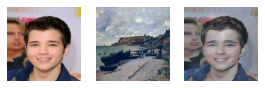

Epoch 26/30
134/134 [==============================] - 127s 932ms/step - loss: 146552.1347


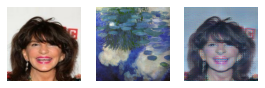

Epoch 27/30
134/134 [==============================] - 127s 933ms/step - loss: 145267.4229


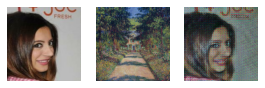

Epoch 28/30
134/134 [==============================] - 127s 932ms/step - loss: 144184.9662


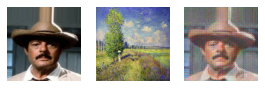

Epoch 29/30
134/134 [==============================] - 127s 932ms/step - loss: 143968.8845


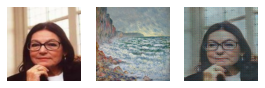

Epoch 30/30
134/134 [==============================] - 127s 934ms/step - loss: 142833.0047


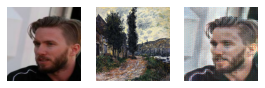

In [40]:
stn = ArbitraryStyleTransfer()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            1e-4, decay_steps=200, decay_rate=0.96, staircase=True)

stn.compile(Adam(lr_schedule))
callbacks = [GenerativeCallback(test_dataset, 1, 1)]

stn.fit(train_dataset, epochs = 30, callbacks = callbacks)